# LAB - CUDA VISION SS 22

Done by - 
- Qasid Saleem
- Mohammad Munirud Doja
- Omar Eldahshoury

List of Key Required Modules - 
- pytorch -> 1.12.1
- pytorch-lightning -> 1.7.7
- scikit-learn -> 1.1.2
- pytorch-msssim

In [ ]:
#Ideally one can run this cell to install requirement
! pip install -r requirements.txt

<h3 id=import> Importing Modules </h3>

In [1]:
import argparse
import os
import sys
import pprint

import numpy as np
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
import torch

from data import Human2dJoints, HumanHeatmaps
from models import StateSpace2dJoints
import utils
from visualization import plot_pred_2d
from data import Human36_data_module
from lit_models import LitModule

from lit_models import un_normalize_joints

<h3 id="skeleton">Project Skeleton</h3>

<p id="general">The general structure of project is as follows:>


<span style='font-family:courier'><p1><left>
&emsp;|── H36PoseForecasting<br>
   &emsp;&emsp; |── configs ,..... <br>
   &emsp;&emsp; |── constants ,..... <br>
   &emsp;&emsp; |── checkpoints<br>
   &emsp;&emsp; |── data ,..... <br>
   &emsp;&emsp; |── data_folder<br>
        &emsp;&emsp;&emsp; |── h36m_train.pkl<br>
        &emsp;&emsp;&emsp; |── h36m_validation.pkl<br>
   &emsp;&emsp; |── lit_models ,..... <br>
   &emsp;&emsp; |── models ,..... <br>
   &emsp;&emsp; |── visualization<br>
   &emsp;&emsp; |── run_experiment.py<br>
   &emsp;&emsp; |── test.py<br>
   &emsp;&emsp; |── tune_hyperparameters.py<br>
   &emsp;&emsp; |── utils.py<br>
    </left>
    </p1>
    </span>

We declare some constants here like data_dir, working_dir, but please change them in constants/__init__.py file before running run_experiment.py, test.py file and tune_hyperparams.py file

The data is not uploaded on github but it is available on google drive https://drive.google.com/drive/folders/1XE6crQ57Cfv9rNCmjGGTbcl0XsMddnlP?usp=sharing
for ease one can run the cell below to download it


In [4]:
import pathlib
pathlib.Path("./data_folder").mkdir(parents=True, exist_ok=True)
%cd data_folder
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1PJ3B2QiFrCJzSPM04Fo-U-u7xCxVua6c' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1PJ3B2QiFrCJzSPM04Fo-U-u7xCxVua6c" -O  h36m_train.pkl && rm -rf /tmp/cookies.txt
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1WvjvvagWv2BgU57OR1P8YbaulBAtmfMC' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1WvjvvagWv2BgU57OR1P8YbaulBAtmfMC" -O  h36m_validation.pkl && rm -rf /tmp/cookies.txt
!unzip h36m_train.zip
!unzip h36m_validation.zip
%cd ..


/home/user/saleemq0/project/H36Pose/H36PoseForecasting/data_folder
--2022-09-30 04:51:54--  https://docs.google.com/uc?export=download&confirm=t&id=1PJ3B2QiFrCJzSPM04Fo-U-u7xCxVua6c
Resolving docs.google.com (docs.google.com)... 142.250.74.206, 2a00:1450:4001:803::200e
Connecting to docs.google.com (docs.google.com)|142.250.74.206|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-as-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/p7kvttdhsj446emaoe5i31rm5f372hcl/1664506275000/09334462889734958336/*/1PJ3B2QiFrCJzSPM04Fo-U-u7xCxVua6c?e=download&uuid=a5976353-1f96-498e-95f3-2f31c720f0e5 [following]
--2022-09-30 04:51:55--  https://doc-0g-as-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/p7kvttdhsj446emaoe5i31rm5f372hcl/1664506275000/09334462889734958336/*/1PJ3B2QiFrCJzSPM04Fo-U-u7xCxVua6c?e=download&uuid=a5976353-1f96-498e-95f3-2f31c720f0e5
Resolving doc-0g-as-docs.googleusercontent.com (d

Loading model and the data set

In [2]:
# The whole project is desingned around argparse
args = {}
# Path of a JSON configuration file
# Tell which model and which data set to use
# along with their parameters
# Check configs folder
data_dir = "./data_folder"
args["config"] = "./configs/joints/statespace.json"
args["config"] = utils.get_config(args)
args["config"]["data"]["train_file"] = f'{data_dir}/{args["config"]["data"]["train_file"]}'
args["config"]["data"]["valid_file"] = f'{data_dir}/{args["config"]["data"]["valid_file"]}'
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(args["config"])


{   'data': {   'batch_size': 64,
                'dataset': 'joints',
                'n_seqs': 20,
                's_fname': 'scaler.joblib',
                's_type': 'normalize',
                'shuffle_data': True,
                'train_file': './data_folder/h36m_train.pkl',
                'valid_file': './data_folder/h36m_validation.pkl'},
    'description': 'basic state space model',
    'loss': 'L1Loss',
    'lr': 0.001344,
    'model': {   'cell_type': 'LSTM',
                 'decoder_fixed_input': False,
                 'encoder_layers': [32],
                 'input_dim': 34,
                 'n_cells': 2,
                 'n_seeds': 10,
                 'name': 'StateSpace2dJoints',
                 'residual_step': True,
                 'rnn_dim': 32}}


In [9]:
data = Human2dJoints(
                data_file=args["config"]["data"]["train_file"],
                mode="train",
                **args["config"]["data"]
)


unrolling joint vectors: 100%|██████████| 9448/9448 [00:00<00:00, 64546.78it/s]


In [20]:
model = StateSpace2dJoints(**args["config"]["model"])

We are using pytorch lightning to train and test models, there are three key things that we need:
1. Data Module (It create the torch datasets objects and is used to get the data loaders)
2. Lightning Module (It is an interface over the torch model, it has boilerplate to train, validate, and test the model)
3. Trainer (It takes the Data Module and lightning module as arguments and performs the training and testing)

In [32]:
# Creating data module object
# num of workers for dataloaders
args["num_workers"] = 2
args["optimizer"] = "Adam"
args["loss"] = "MSELoss"
args["lr"] = 1e-3

data_module = Human36_data_module(args)
lit_model = LitModule(model, args)

In [3]:
# can be done using a util function
args["num_workers"] = 2
args["optimizer"] = "Adam"
args["loss"] = "MSELoss"
args["lr"] = 1e-3
args["config"] = "./configs/joints/statespace.json"
args["exp_name"] = "demo_model"
data_module,lit_model, args = utils.setup_data_and_model_from_args(args)

In [6]:
# Now let's define a trainer
args["accelerator"] = "cpu" # can be gpu
args["devices"] = 1 # number of gpus/cpus
args["num_epochs"] = 1
 
trainer = pl.Trainer(
    accelerator=args["accelerator"],
    devices=args["devices"],
    max_epochs=args["num_epochs"],
)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/user/saleemq0/assignment_8/env/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1764: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


In [7]:
# Train model
trainer.fit(
    lit_model,
    data_module
)

Missing logger folder: /home/user/saleemq0/project/H36Pose/H36PoseForecasting/lightning_logs
unrolling joint vectors: 100%|██████████| 3324/3324 [00:00<00:00, 70658.27it/s]

  | Name    | Type               | Params
-----------------------------------------------
0 | model   | StateSpace2dJoints | 56.4 K
1 | loss_fn | L1Loss             | 0     
-----------------------------------------------
56.4 K    Trainable params
0         Non-trainable params
56.4 K    Total params
0.225     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/user/saleemq0/assignment_8/env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/user/saleemq0/assignment_8/env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


In [10]:
# Test model
trainer.test(lit_model, data_module.val_dataloader())

unrolling joint vectors: 100%|██████████| 3324/3324 [00:00<00:00, 68150.73it/s]
/home/user/saleemq0/assignment_8/env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_MAE            23.593809127807617
       test_MPJPE           39.323143005371094
        test_MSE             1892.683837890625
        test_PCK             52.83746337890625
        test_loss          0.024733783677220345
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.024733783677220345,
  'test_MSE': 1892.683837890625,
  'test_MAE': 23.593809127807617,
  'test_MPJPE': 39.323143005371094,
  'test_PCK': 52.83746337890625}]

In [12]:
# Do inference
predictions = trainer.predict(lit_model, data_module.val_dataloader())

unrolling joint vectors: 100%|██████████| 3324/3324 [00:00<00:00, 71390.58it/s]
/home/user/saleemq0/assignment_8/env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 148it [00:00, ?it/s]

In [14]:
predictions = torch.vstack(predictions)

In [17]:
predictions = un_normalize_joints(args, predictions)

In [18]:
predictions = predictions.numpy()

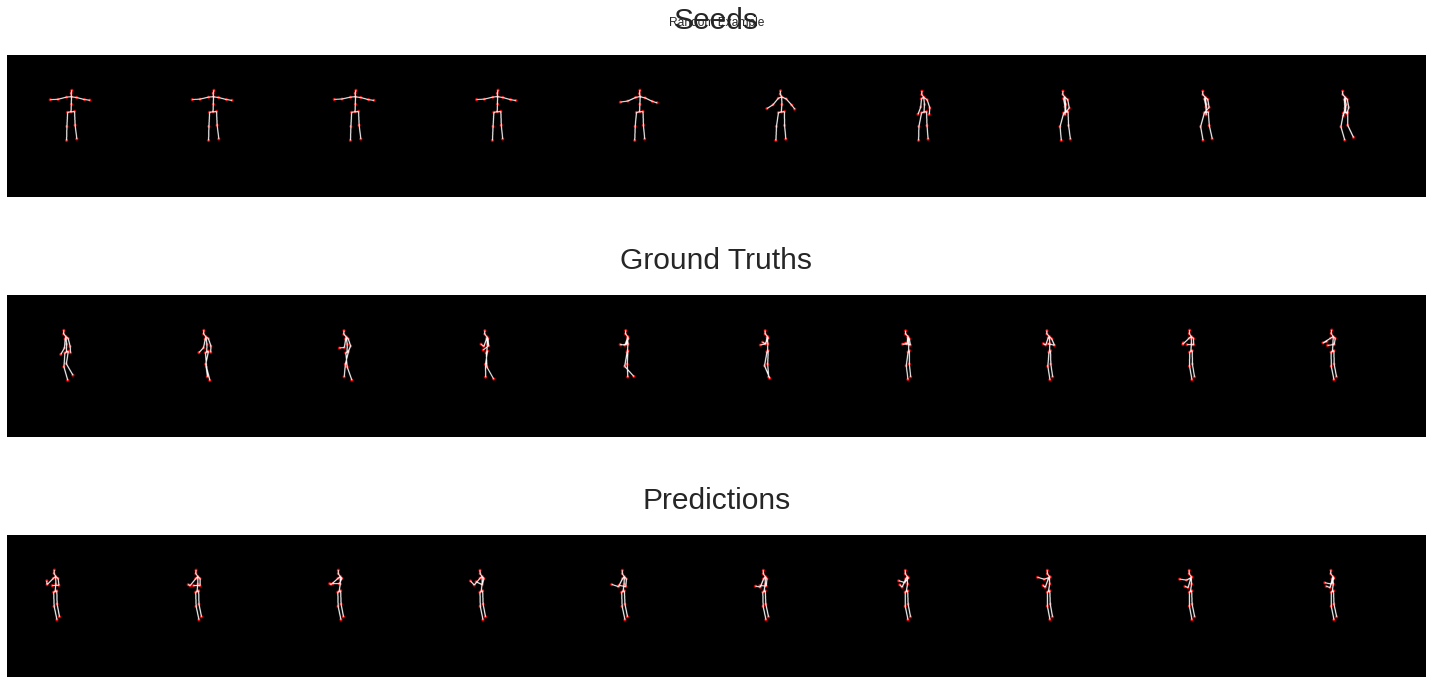

In [19]:
# Each prediction has 30 frames 10 seeds, 10 targets and 10 prediction
idx = 0
pred_to_plot = predictions[idx]
seeds = pred_to_plot[0:10]
gt = pred_to_plot[10:20]
pred = pred_to_plot[20:]
fig = plot_pred_2d(seeds, gt, pred)

The steps discussed were manual step but one can train and test
model using a single command


In [21]:
# for training you have run run_experiment.py file
!python3 run_experiment.py --help

Global seed set to 42
usage: run_experiment.py [-h] [--config CONFIG] [--num_epochs NUM_EPOCHS]
                         [--load_checkpoint LOAD_CHECKPOINT]
                         [--optimizer OPTIMIZER] [--wandb] [--lr LR]
                         [--loss {MSELoss,L1Loss,SSIMLoss}]
                         [--one_cycle_max_lr ONE_CYCLE_MAX_LR]
                         [--one_cycle_total_steps ONE_CYCLE_TOTAL_STEPS]
                         [--use_es] [--n_checkpoints N_CHECKPOINTS]
                         [--patience PATIENCE] [--mode {min,max}]
                         [--monitor {val_loss,train_loss,val_PCK}]
                         [--exp_name EXP_NAME] [--accelerator ACCELERATOR]
                         [--devices DEVICES] [--num_workers NUM_WORKERS]
                         [--pin_memory PIN_MEMORY]
                         [--project_name PROJECT_NAME]

optional arguments:
  -h, --help            show this help message and exit
  --config CONFIG       JSON config file
  --n

There are a lot of parameters, we are using weights and baises
for experiment monitoring. To do the set you just have to use --wandb flag and provide the project_name. An example command is given below:

In [ ]:
!python3 run_experiment.py --config="./configs/heatmaps/autoregressive.json" \
 --exp_name="heatmaps_autoregressive_best_config"\
 --num_workers=4 --wandb --num_epochs=50 --devices=1

 # devices can be > 1 if you want to do multi-gpu training

For testing you need a trained checkpoint and a config file 
for ease you can provide the same config file the one that was used in training. --save_visuals is provided 10 random prediction will be shown in checkpoint/model/exp_name/images directory


In [2]:
!python3 test.py --help

Global seed set to 42
usage: test.py [-h] [--config CONFIG] [--checkpoint CHECKPOINT]
               [--optimizer OPTIMIZER] [--wandb] [--save_preds]
               [--save_visuals] [--lr LR] [--loss {MSELoss,L1Loss,SSIMLoss}]
               [--exp_name EXP_NAME] [--accelerator ACCELERATOR]
               [--devices DEVICES] [--num_workers NUM_WORKERS]
               [--pin_memory PIN_MEMORY] [--project_name PROJECT_NAME]
               [--wandb_id WANDB_ID]

optional arguments:
  -h, --help            show this help message and exit
  --config CONFIG       JSON config file
  --checkpoint CHECKPOINT
                        path of the model checkpoint
  --optimizer OPTIMIZER
                        Optimizer
  --wandb               If passed, logs experiment results to Weights & Biases
  --save_preds          If passed predictions are saved as a numpy array
  --save_visuals        If passed 10 random result images are saved
  --lr LR               Learning Rate
  --loss {MSELoss,L1Loss

In [3]:
# Example if one want to explore predictions
checkpoint_path = ""
args = {
   "config": "./configs/joints/autoregressive.json",
    "exp_name": "joints_autoregressive_best_config",
    "loss": "MSELoss",
    "optimizer": "Adam",
    "num_workers": 4,
    "checkpoint": checkpoint_path,
    "save_preds": True,
    "save_visuals": True,
    "wandb": True,
    "project_name": "CUDALAB",
    "wandb_id": False
}
from test import run_test
predictions = run_test(args)

In [ ]:
# or
!python3 test.py --exp_name="joints_autoregressive_best_config" \
    --config="./configs/heatmaps/autoregressive.json" \
    --exp_name="heatmaps_autoregressive_best_config" \
    --save_preds --save_visuals --wandb


In [ ]:
# The project also has hyperparameter tunining functionality
# we use weights and baises sweeps
!python3 tune_hyperparams.py \
--config="./configs/joints/statespace.json"\
--exp_name="joints_state_space_wandb_sweep"\
--num_workers=4 --num_runs=1 --num_epochs=200

#num_runs means how many experiments one wants to do